In [1]:
import random
import torch

import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

## Settings

In [2]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer4'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|██████████| 2048/2048 [00:17<00:00, 120.40it/s]


torch.Size([2048, 20000])


## Visualize Results


 Layer:layer4 Neuron:1495
1st description: drawers, sim:0.138
2nd description: deskjet, sim:0.129
3rd description: bureau, sim:0.126
5 most highly activating images in D_probe:


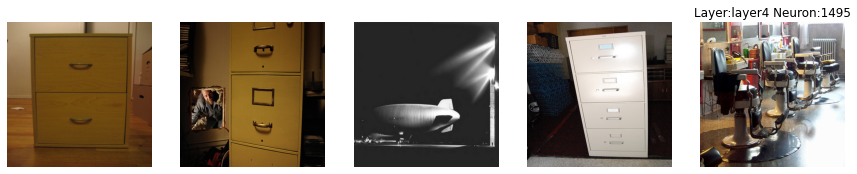


 Layer:layer4 Neuron:1253
1st description: fence, sim:0.481
2nd description: fences, sim:0.463
3rd description: radiator, sim:0.355
5 most highly activating images in D_probe:


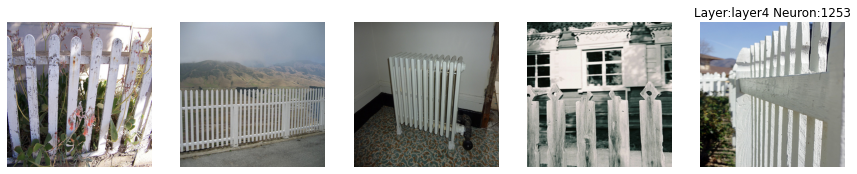


 Layer:layer4 Neuron:583
1st description: snake, sim:0.497
2nd description: cobra, sim:0.454
3rd description: juvenile, sim:0.439
5 most highly activating images in D_probe:


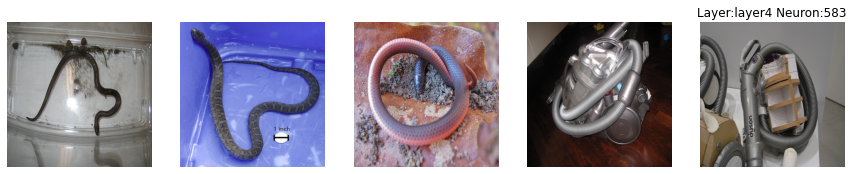


 Layer:layer4 Neuron:1195
1st description: piano, sim:0.317
2nd description: pianist, sim:0.285
3rd description: organ, sim:0.223
5 most highly activating images in D_probe:


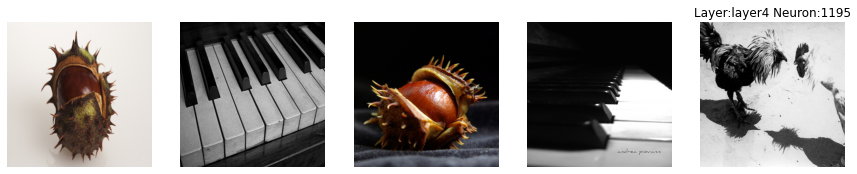


 Layer:layer4 Neuron:394
1st description: bookshop, sim:0.429
2nd description: bookstore, sim:0.392
3rd description: bookstores, sim:0.374
5 most highly activating images in D_probe:


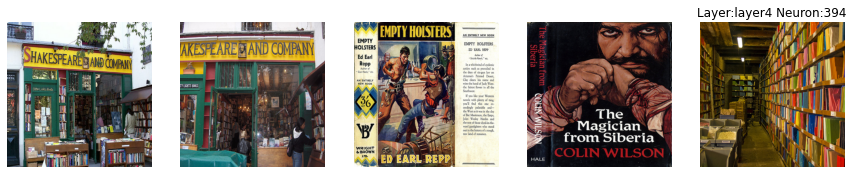


 Layer:layer4 Neuron:97
1st description: fasteners, sim:0.368
2nd description: screws, sim:0.341
3rd description: screw, sim:0.258
5 most highly activating images in D_probe:


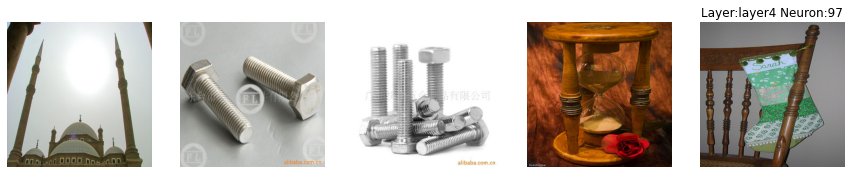


 Layer:layer4 Neuron:1415
1st description: scooters, sim:0.207
2nd description: handicapped, sim:0.173
3rd description: handicap, sim:0.173
5 most highly activating images in D_probe:


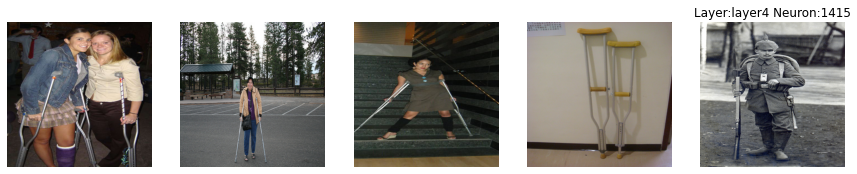


 Layer:layer4 Neuron:985
1st description: graduates, sim:0.191
2nd description: undergraduates, sim:0.190
3rd description: graduation, sim:0.187
5 most highly activating images in D_probe:


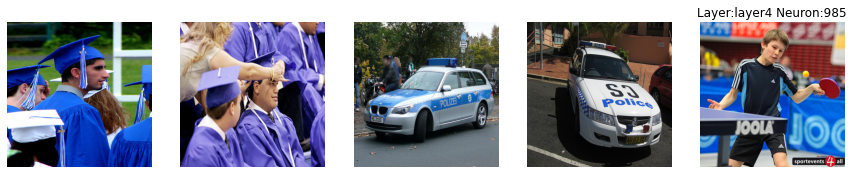


 Layer:layer4 Neuron:1707
1st description: hockey, sim:0.346
2nd description: flyers, sim:0.255
3rd description: contested, sim:0.220
5 most highly activating images in D_probe:


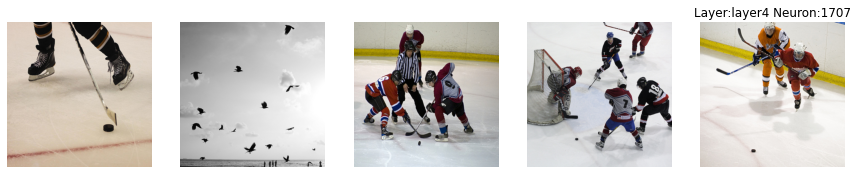


 Layer:layer4 Neuron:532
1st description: kettle, sim:0.267
2nd description: pitcher, sim:0.265
3rd description: mug, sim:0.241
5 most highly activating images in D_probe:


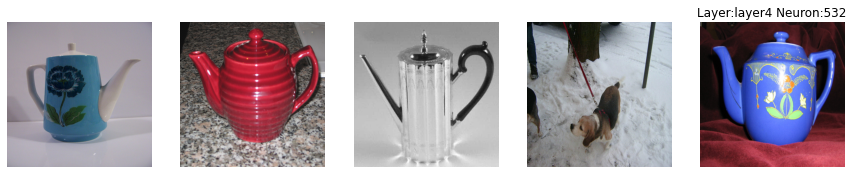

In [5]:
neurons_to_check = ids_to_check = random.sample([i for i in range(target_feats.shape[1])], k=10)
#neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]

ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

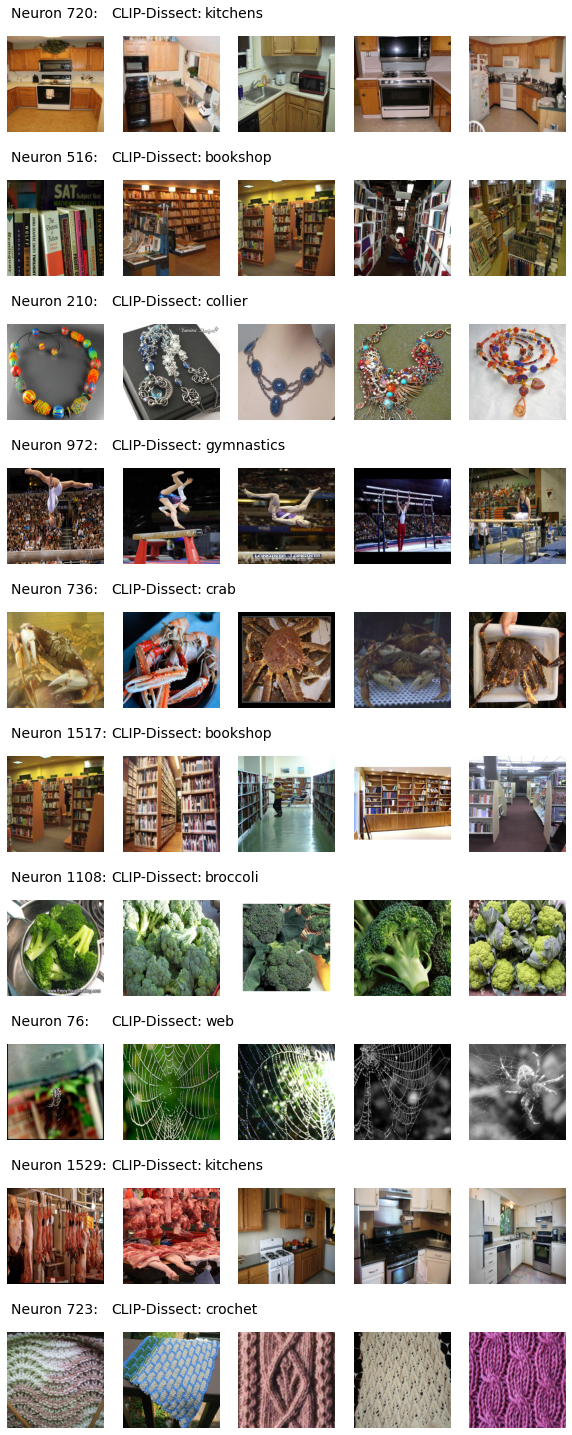

In [6]:
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()